In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import binning

# The following two lines are used to produce IEEE standard plots.
# Uncommenting will only change the appearance of plots.
import scienceplots
plt.style.use(['science', 'ieee'])

FIGSIZE_ONE_COLUMN = plt.rcParams['figure.figsize']
GENERATE_NEW_DATA = False # Set to 'True' to re-run experiments and overwrite .csv files in 'plot_data'.
DO_EXTRA_CHECKS = True # Set to 'True' to perform extra sanity checks during computations.

## Code for generating the data

The code below generates and loads data used for producing Figures 3, 4 and 5.
The data is stored in 'plot_data' in .csv format.

In [2]:
def generate_type1_figure_data(max_n, factor_off_list, error_type, save_data=True):
    """ Generates data for Figs. 3(a) and 3(b) from the paper. """

    # Get evenly log-spaced n
    base = 1.1
    n = 2
    n_list = [n]
    while True:
        n *= base
        n = math.ceil(n)
        if n >= max_n:
            break
        n_list.append(n)
    n_list.append(max_n)

    df = pd.DataFrame(columns=factor_off_list, index=n_list)

    for factor_off in factor_off_list:
        print(f"Doing factor_off={factor_off}")
        for n in n_list:

            B = binning.bennett_matrix(n)

            if error_type == 'mean':
                target_error = factor_off * binning.get_mse(B, B)
            elif error_type == 'max':
                target_error = factor_off * binning.get_max_se(B, B)
            else:
                assert(0)

            our_error = 1000 * target_error
            space = None
            d = 2
            while our_error > target_error :

                c = 1 - 1 / d
                L, R, space = binning.approx_bennett_mm(n, c=c, tau=1/n, perform_extra_checks=DO_EXTRA_CHECKS)

                if error_type == 'mean':
                    our_error = binning.get_mse(L, R)
                elif error_type == 'max':
                    our_error = binning.get_max_se(L, R)
                d += 1

            df.at[n, factor_off] = space

    if save_data: 
        df.to_csv(f'plot_data/{error_type}_space_vs_n.csv')
    return df

def get_type1_figure_data(max_n, factor_off_list, error_type):
    """ Loads or generates data for Figs. 3(a) and 3(b) from the paper. """
    if GENERATE_NEW_DATA:
        df = generate_type1_figure_data(max_n, factor_off_list, error_type)
    else:
        df = pd.read_csv(f'plot_data/{error_type}_space_vs_n.csv', index_col=0)
    return df

def generate_type2_figure_data(alpha, beta, n_list, error_type, max_space=100, save_data=True):
    """ Generates data for Figs. 3(c), 3(d) and Fig. 5 from the paper. """
    dfs = {}
    d_list = np.hstack([np.linspace(1.1, 2, 10), np.arange(3, 100, 1)])
    for n in n_list:
        if alpha == 1 and beta == 0: 
            B = binning.bennett_matrix(n)
        else:
            B = binning.get_square_root_matrix(n=n, alpha=alpha, beta=beta)

        if error_type == 'mean':
            baseline_error = binning.get_mse(B, B)
        elif error_type == 'max':
            baseline_error = binning.get_max_se(B, B)
        else:
            assert(0)

        df = pd.DataFrame(index=d_list, columns=['space', 'approx'])
        for d in d_list:
            c = 1 - 1 / d

            # The first computation should be a little faster
            if alpha == 1 and beta == 0:
                L, R, space = binning.approx_bennett_mm(
                    n=n, 
                    c=c,
                    tau=1/n,
                    perform_extra_checks=DO_EXTRA_CHECKS)
            else:
                L, R, space = binning.approx_counting_with_decay_momentum(
                    n=n, 
                    alpha=alpha,
                    beta=beta,
                    c=c,
                    tau=1/n,
                    perform_extra_checks=DO_EXTRA_CHECKS)

            df.at[d, 'space'] = space
            if error_type == 'mean':
                df.at[d, 'approx'] = binning.get_mse(L, R) / baseline_error
            else:
                df.at[d, 'approx'] = binning.get_max_se(L, R) / baseline_error

            if space > max_space:
                break

        dfs[n] = df

        if save_data:
            df.to_csv(f"plot_data/{error_type}_mult_vs_space_a{alpha}b{beta}N{n}.csv")
    return dfs

def get_type2_figure_data(alpha, beta, n_list, error_type):
    """ Loads or generates data for Figs. 3(a) and 3(b) from the paper. """
    dfs = {}
    if GENERATE_NEW_DATA:
        dfs = generate_type2_figure_data(alpha, beta, n_list, error_type)
    else:
        for n in n_list:
            dfs[n] = pd.read_csv(f"plot_data/{error_type}_mult_vs_space_a{alpha}b{beta}n{n}.csv", index_col=0)
    return dfs

# Figures 3(a) and 3(b)

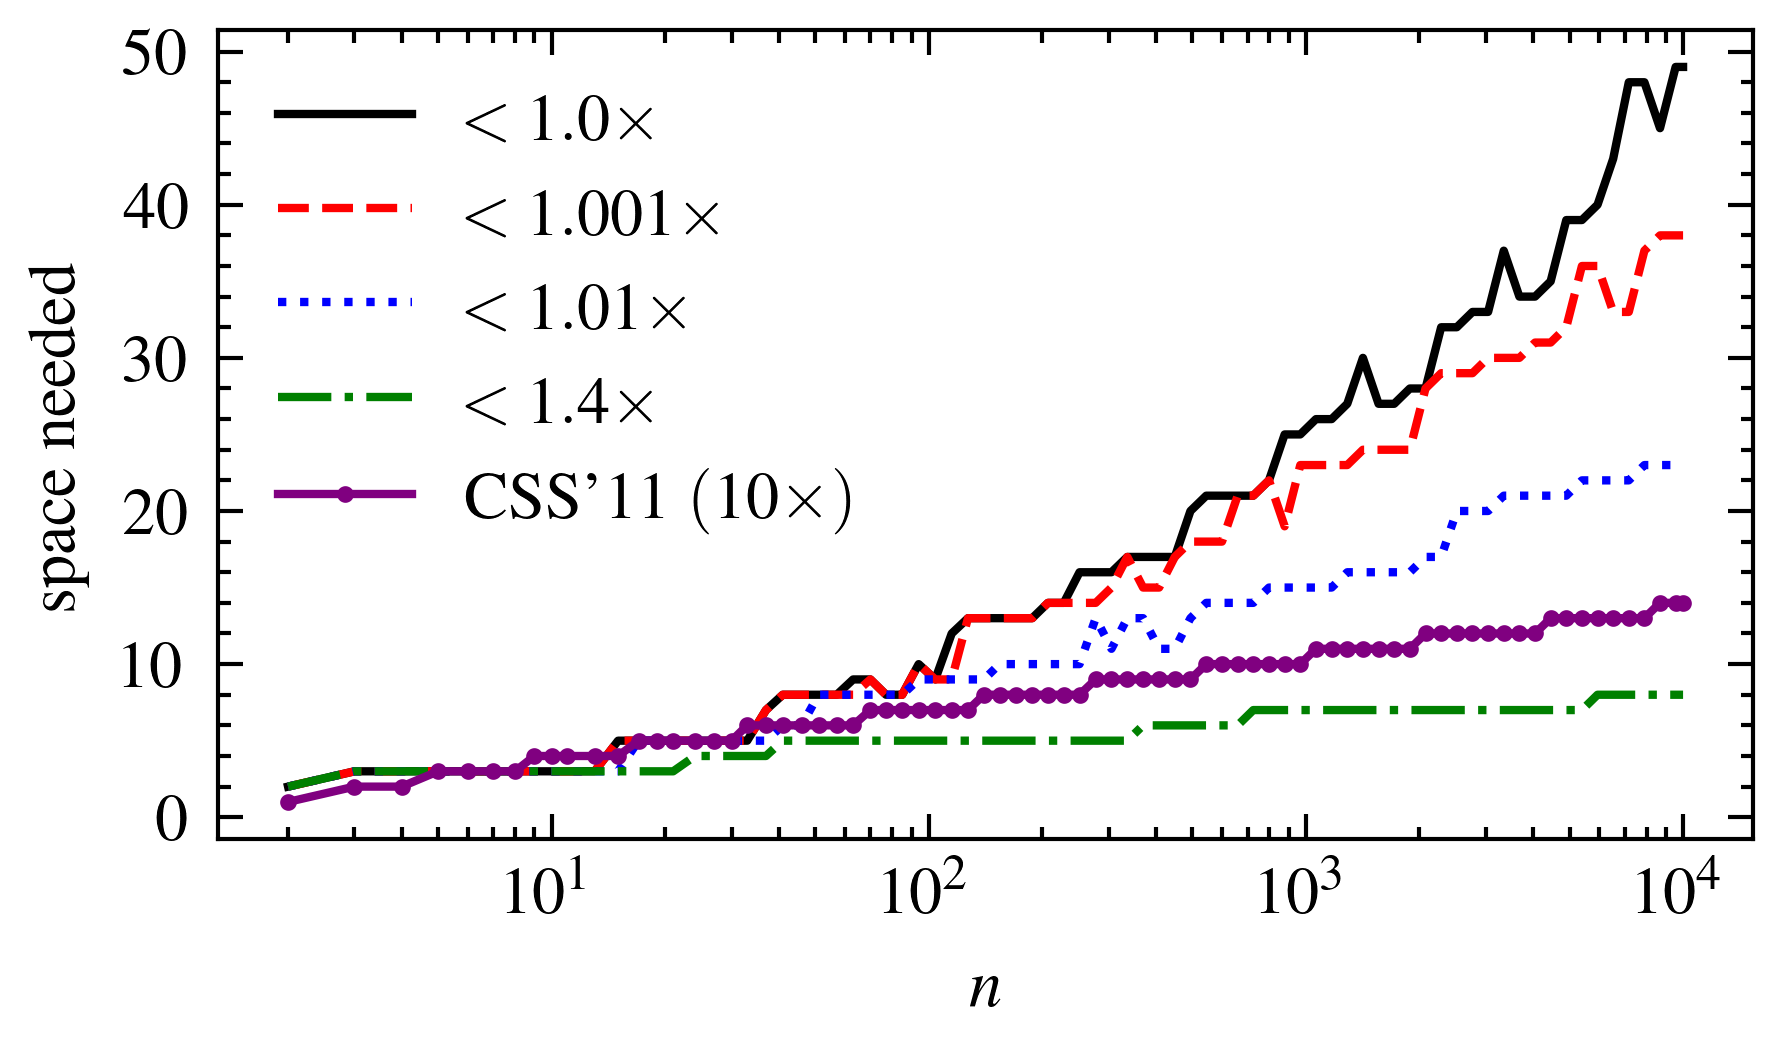

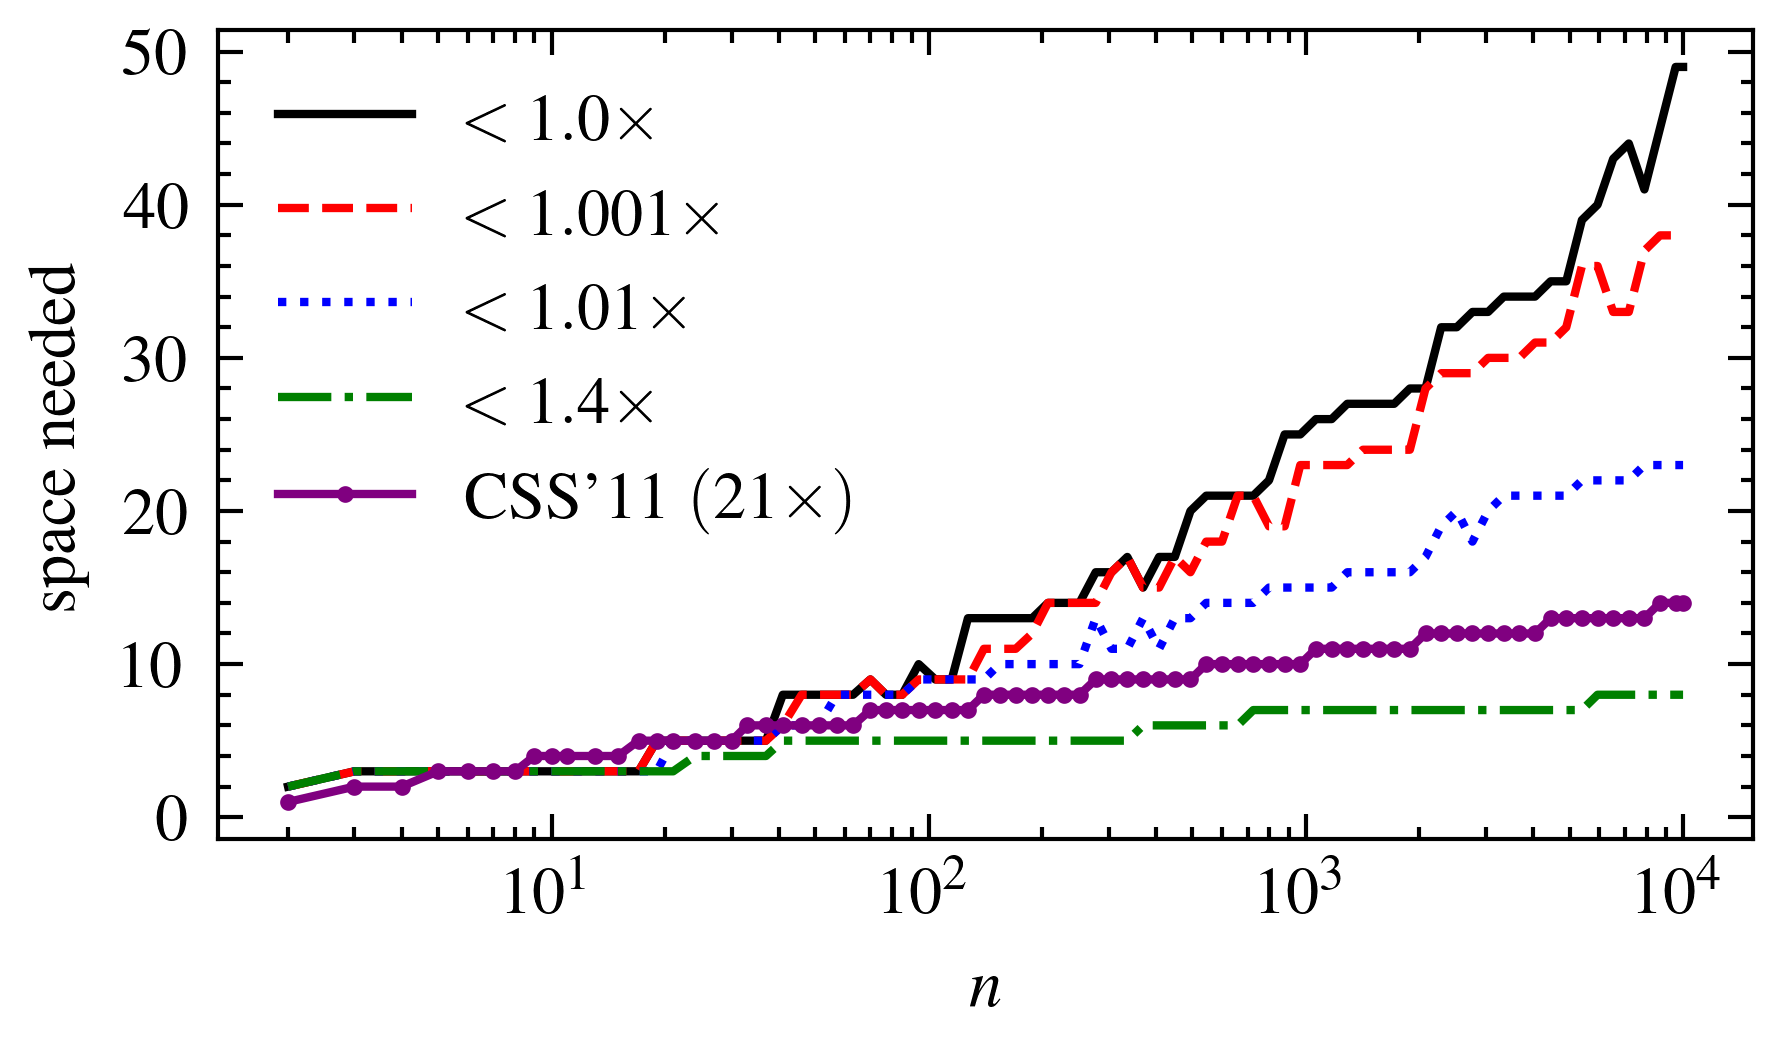

In [3]:
factor_off_list = [1.0, 1.001, 1.01, 1.4]
max_n = 10000
error_type = 'mean'
df = get_type1_figure_data(max_n, factor_off_list, error_type)

plt.figure(figsize=(FIGSIZE_ONE_COLUMN[0], 0.7 * FIGSIZE_ONE_COLUMN[1]))
for factor_off in df.columns:
    plt.plot(df.index, df[factor_off], label=f'$<{factor_off}\\times$')
plt.plot(df.index, np.ceil(np.log2(df.index)), label=r"CSS'11 $(10\times)$", ls='-', marker='.', color='purple', ms=2)
plt.xlabel('$n$')
plt.ylabel('space needed')
plt.legend()
plt.xscale('log')
plt.savefig(f'plots/{error_type}_space_vs_n.pdf', bbox_inches='tight')
plt.show()

error_type = 'max'
df = get_type1_figure_data(max_n, factor_off_list, error_type)
plt.figure(figsize=(FIGSIZE_ONE_COLUMN[0], 0.7 * FIGSIZE_ONE_COLUMN[1]))
for factor_off in df.columns:
    plt.plot(df.index, df[factor_off], label=f'$<{factor_off}\\times$')
plt.plot(df.index, np.ceil(np.log2(df.index)), label=r"CSS'11 $(21\times)$", ls='-', marker='.', color='purple', ms=2)
plt.xlabel('$n$')
plt.ylabel('space needed')
plt.legend()
plt.xscale('log')
plt.savefig(f'plots/{error_type}_space_vs_n.pdf', bbox_inches='tight')
plt.show()

## Figures 3(c), 3(d) and 5

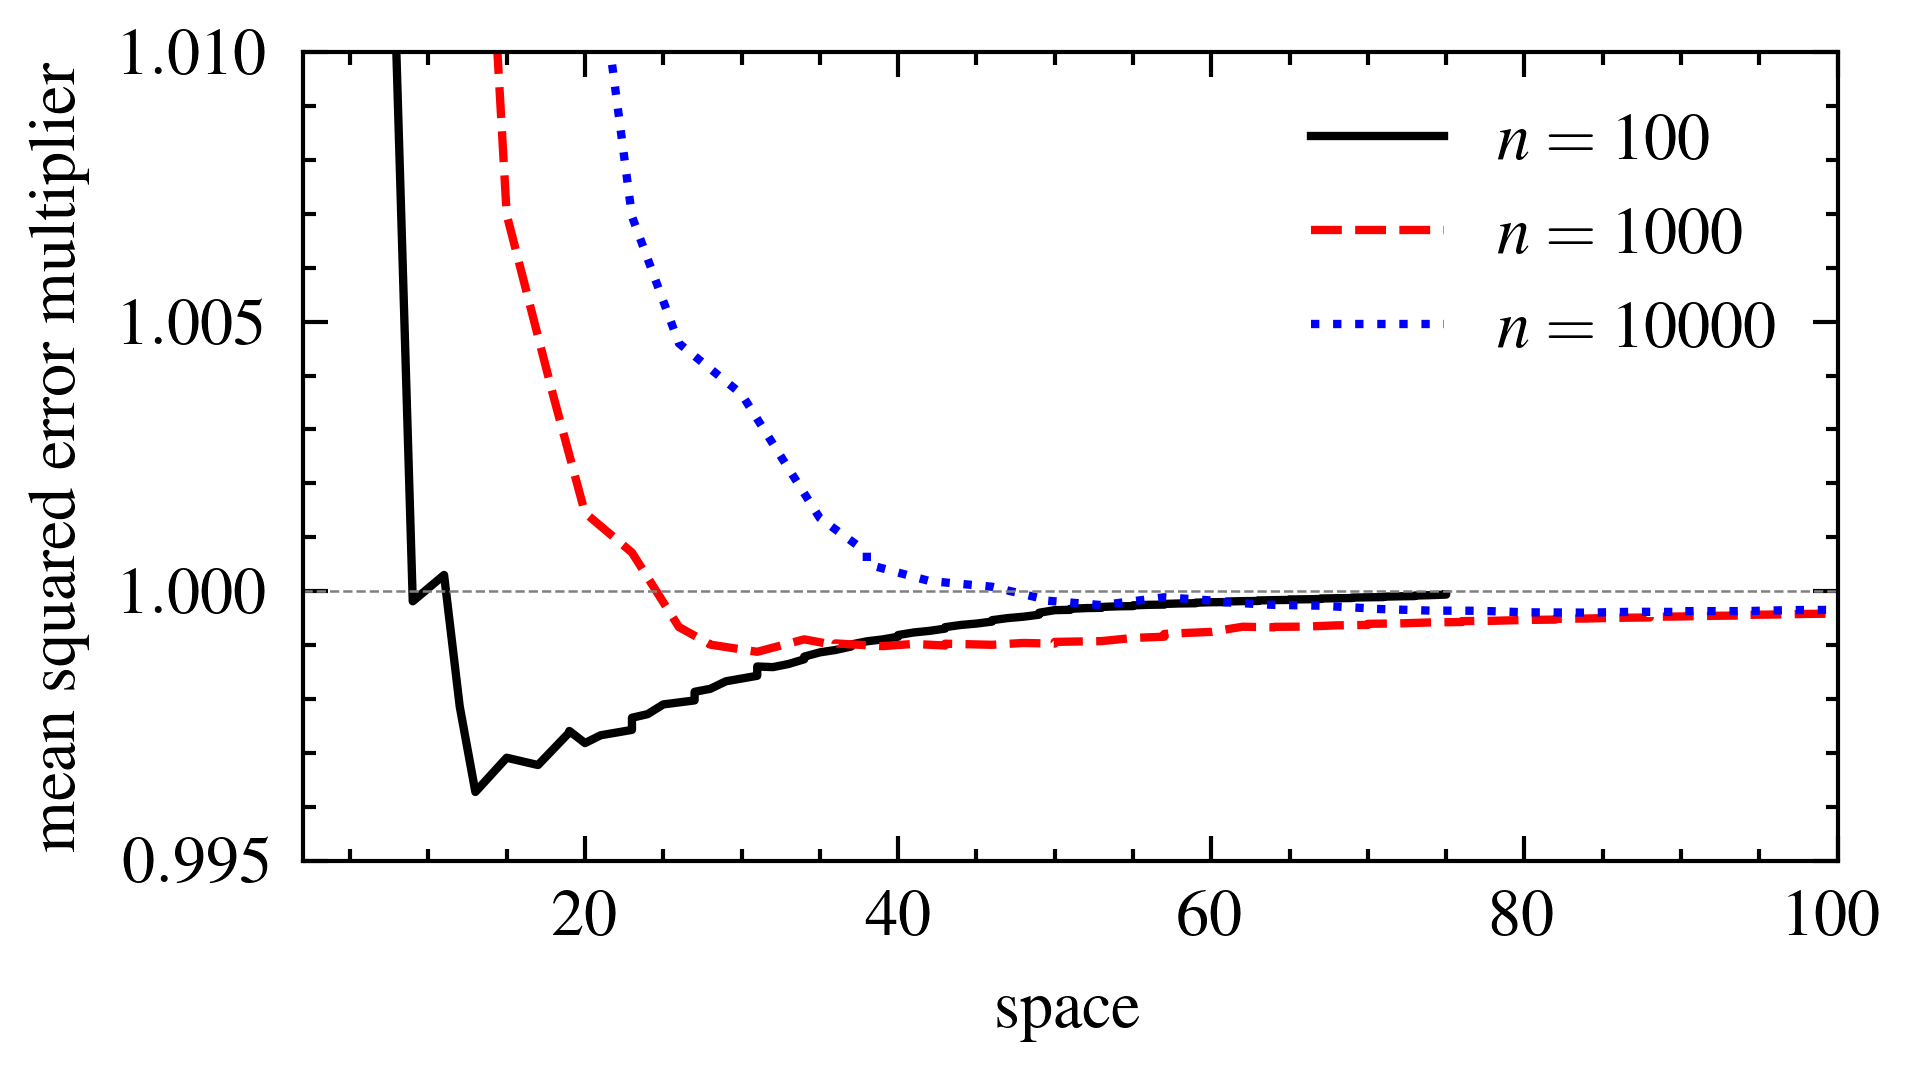

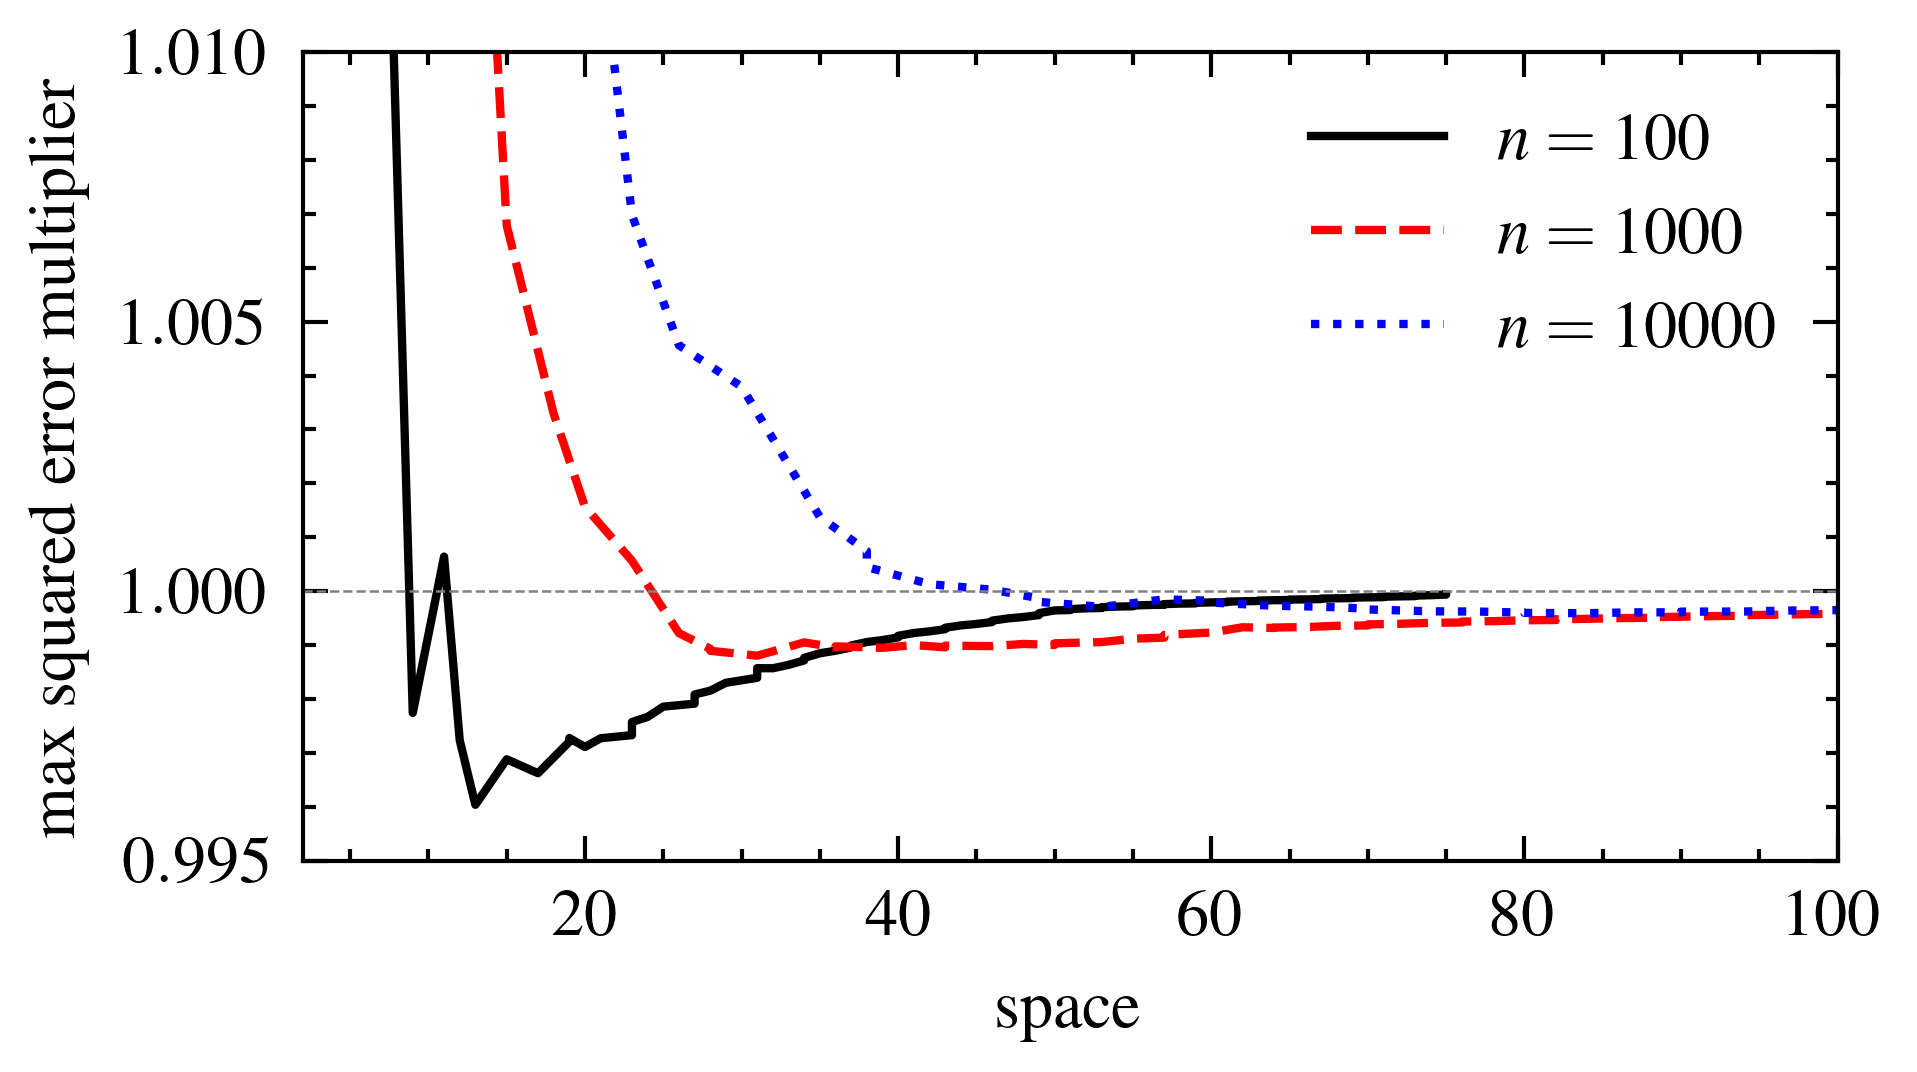

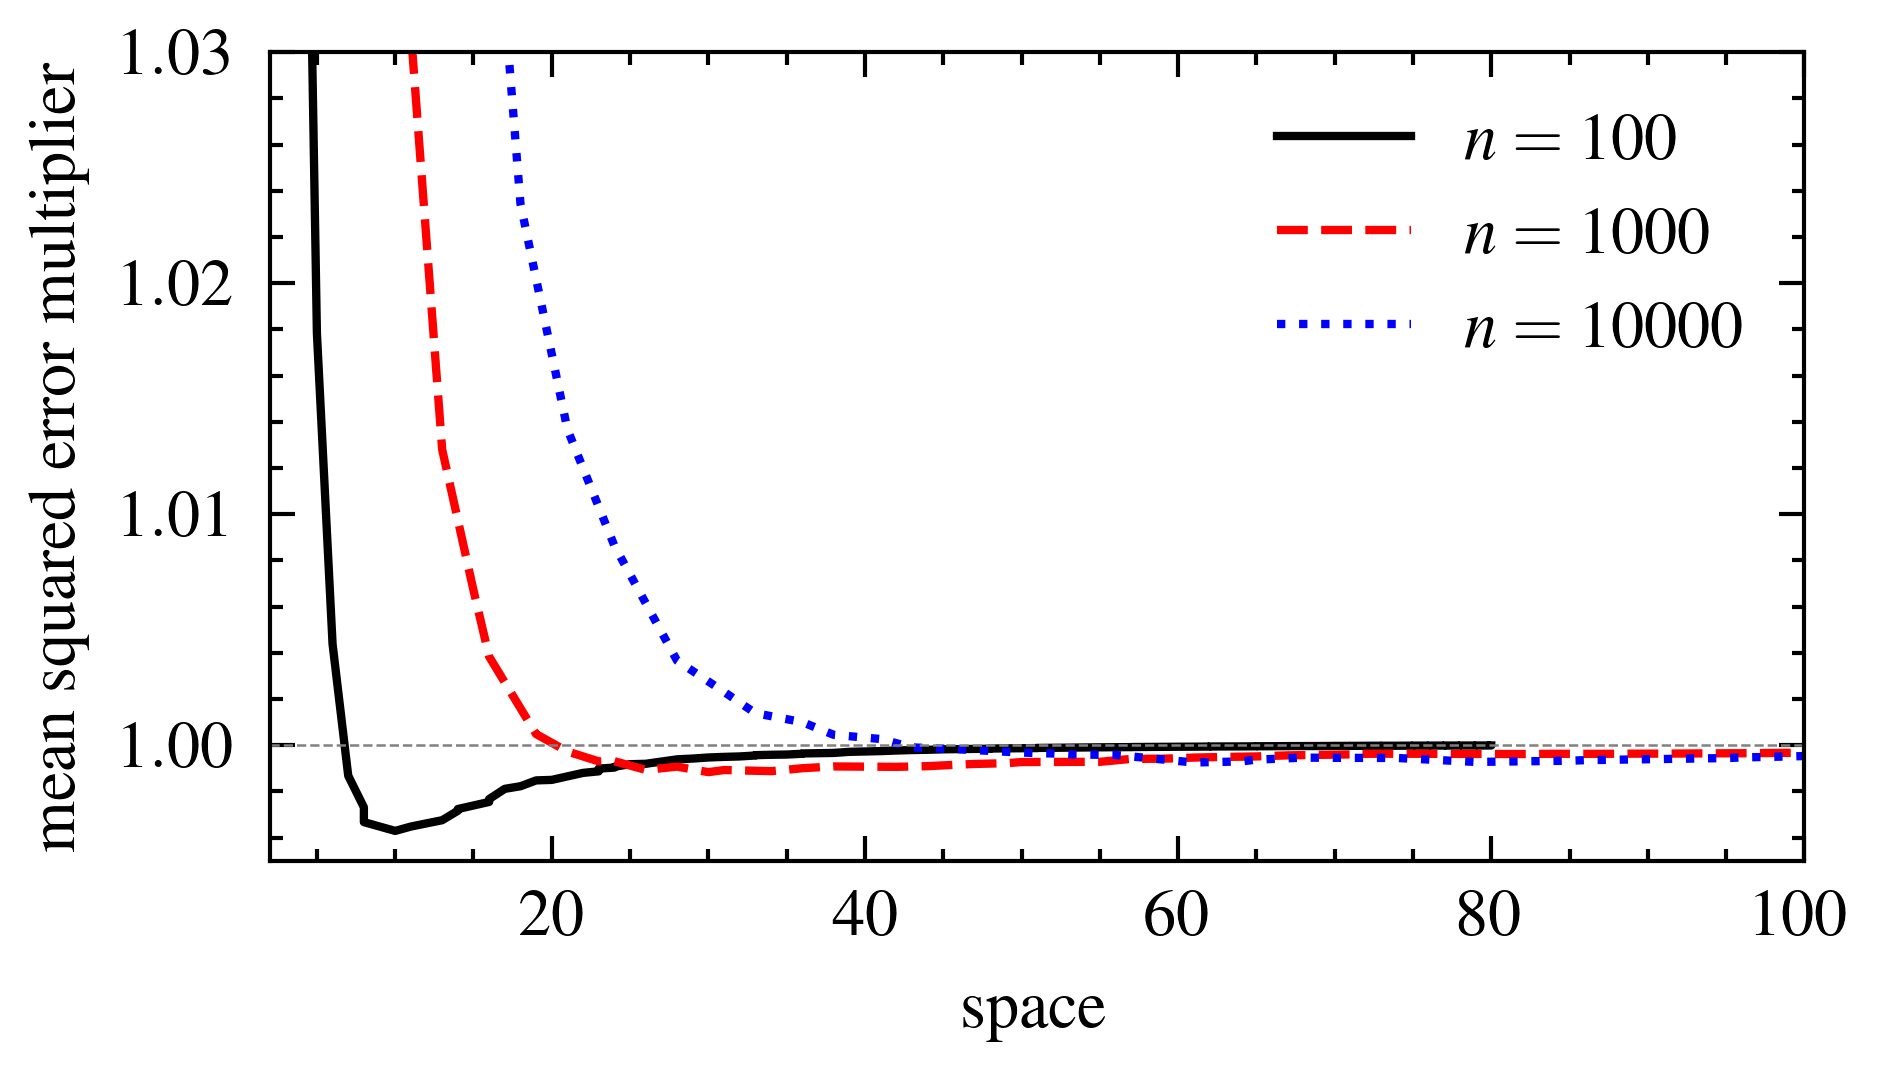

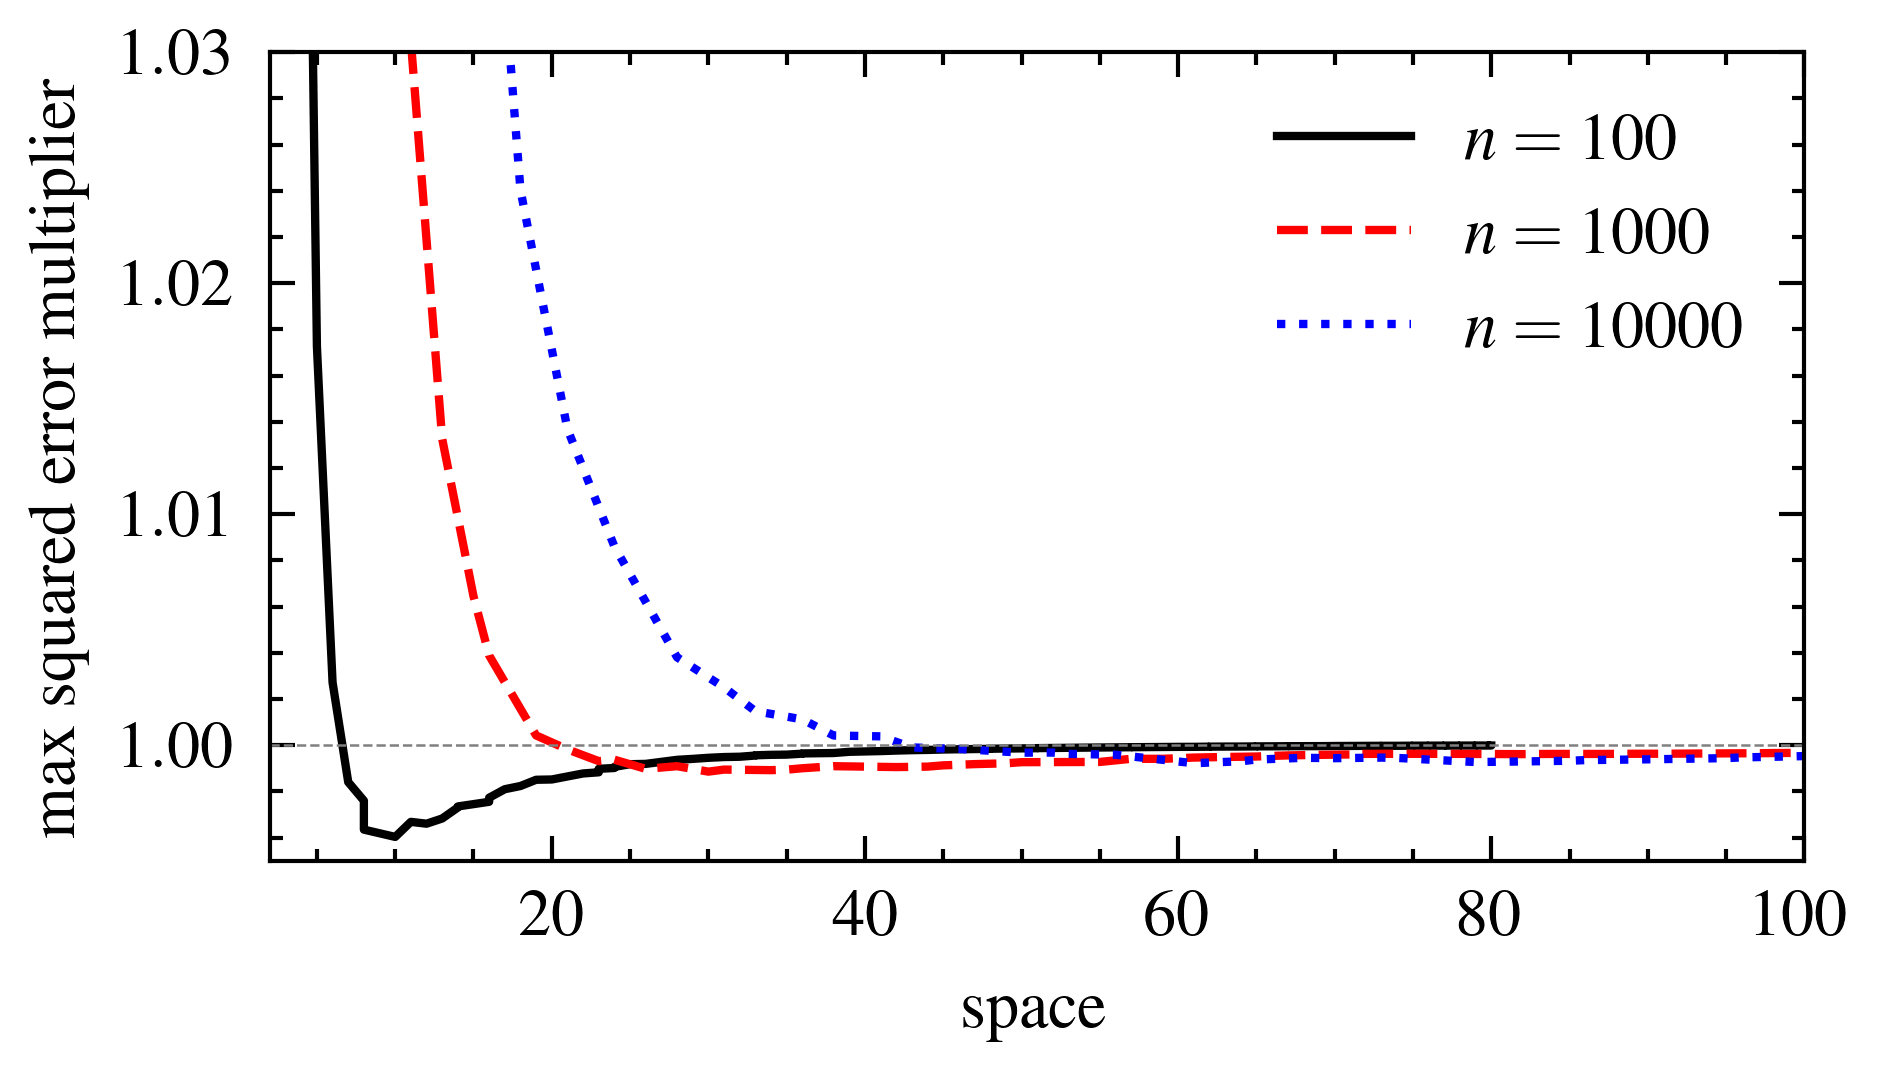

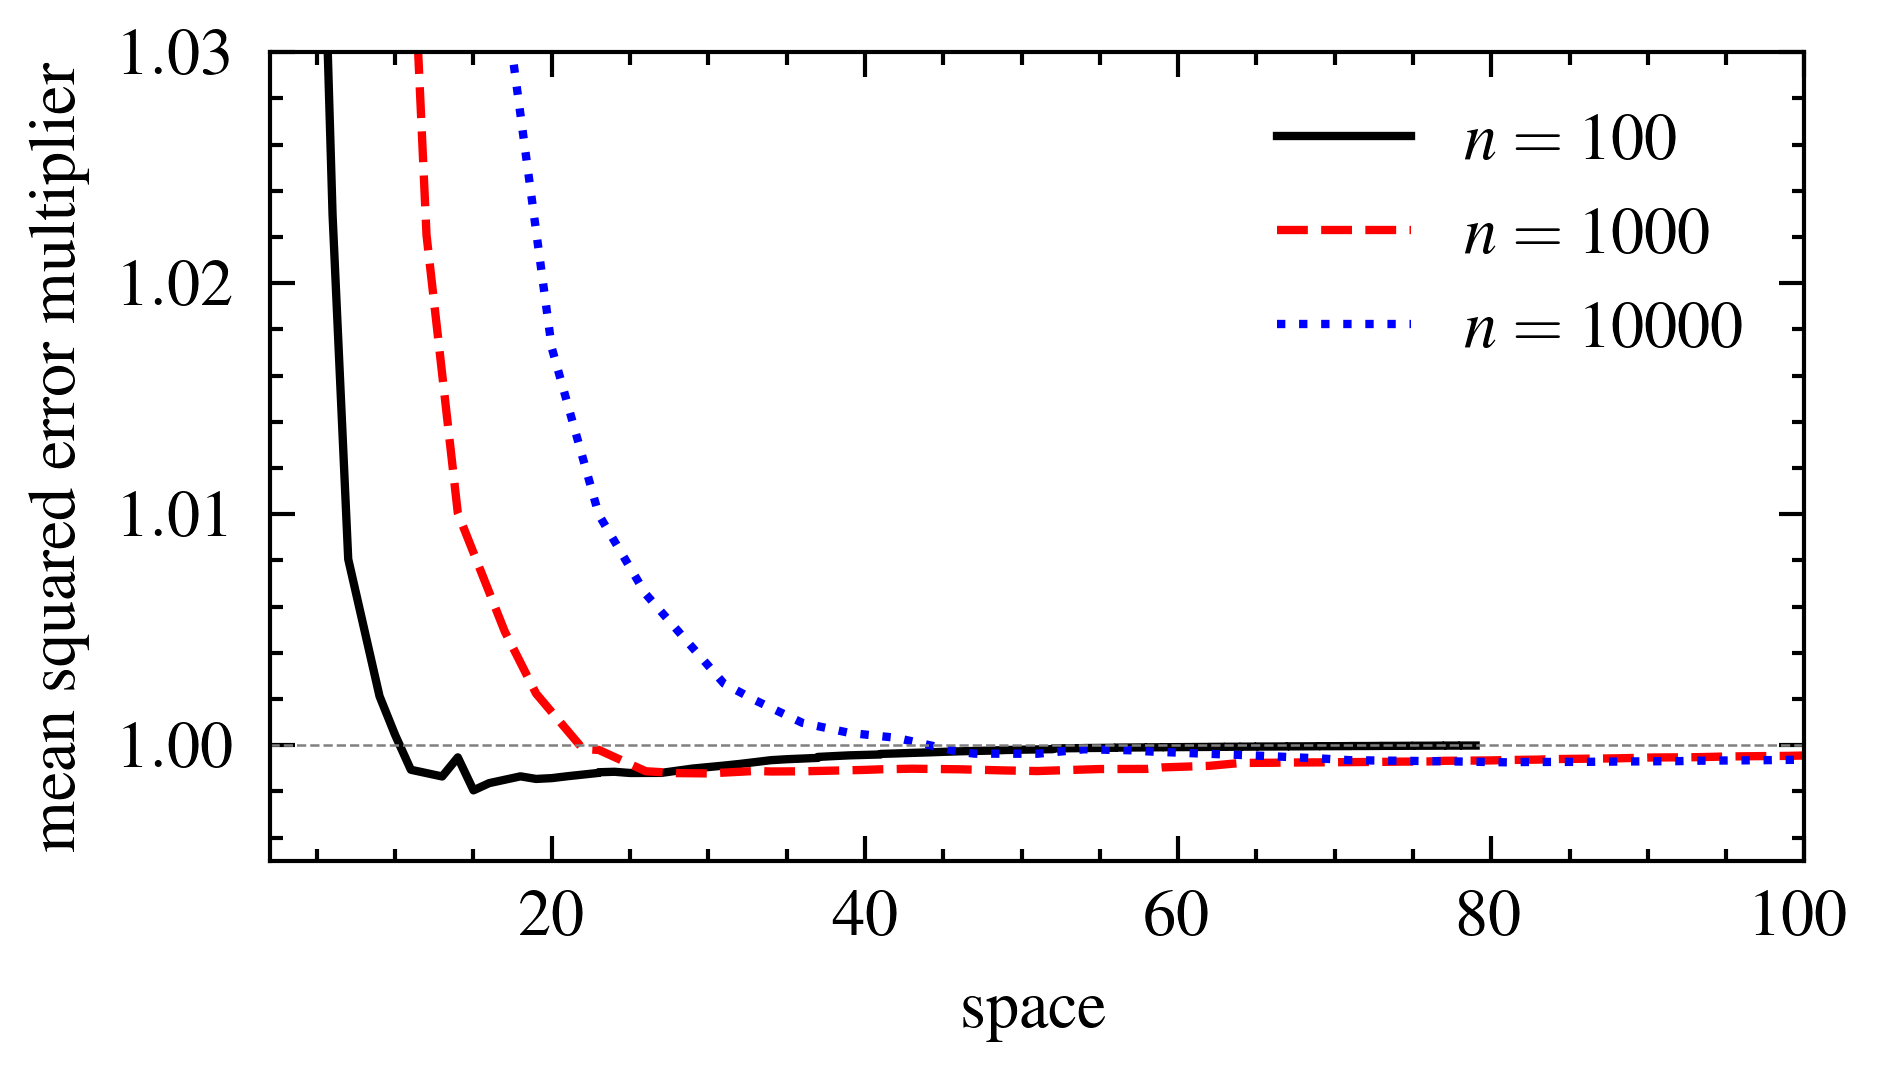

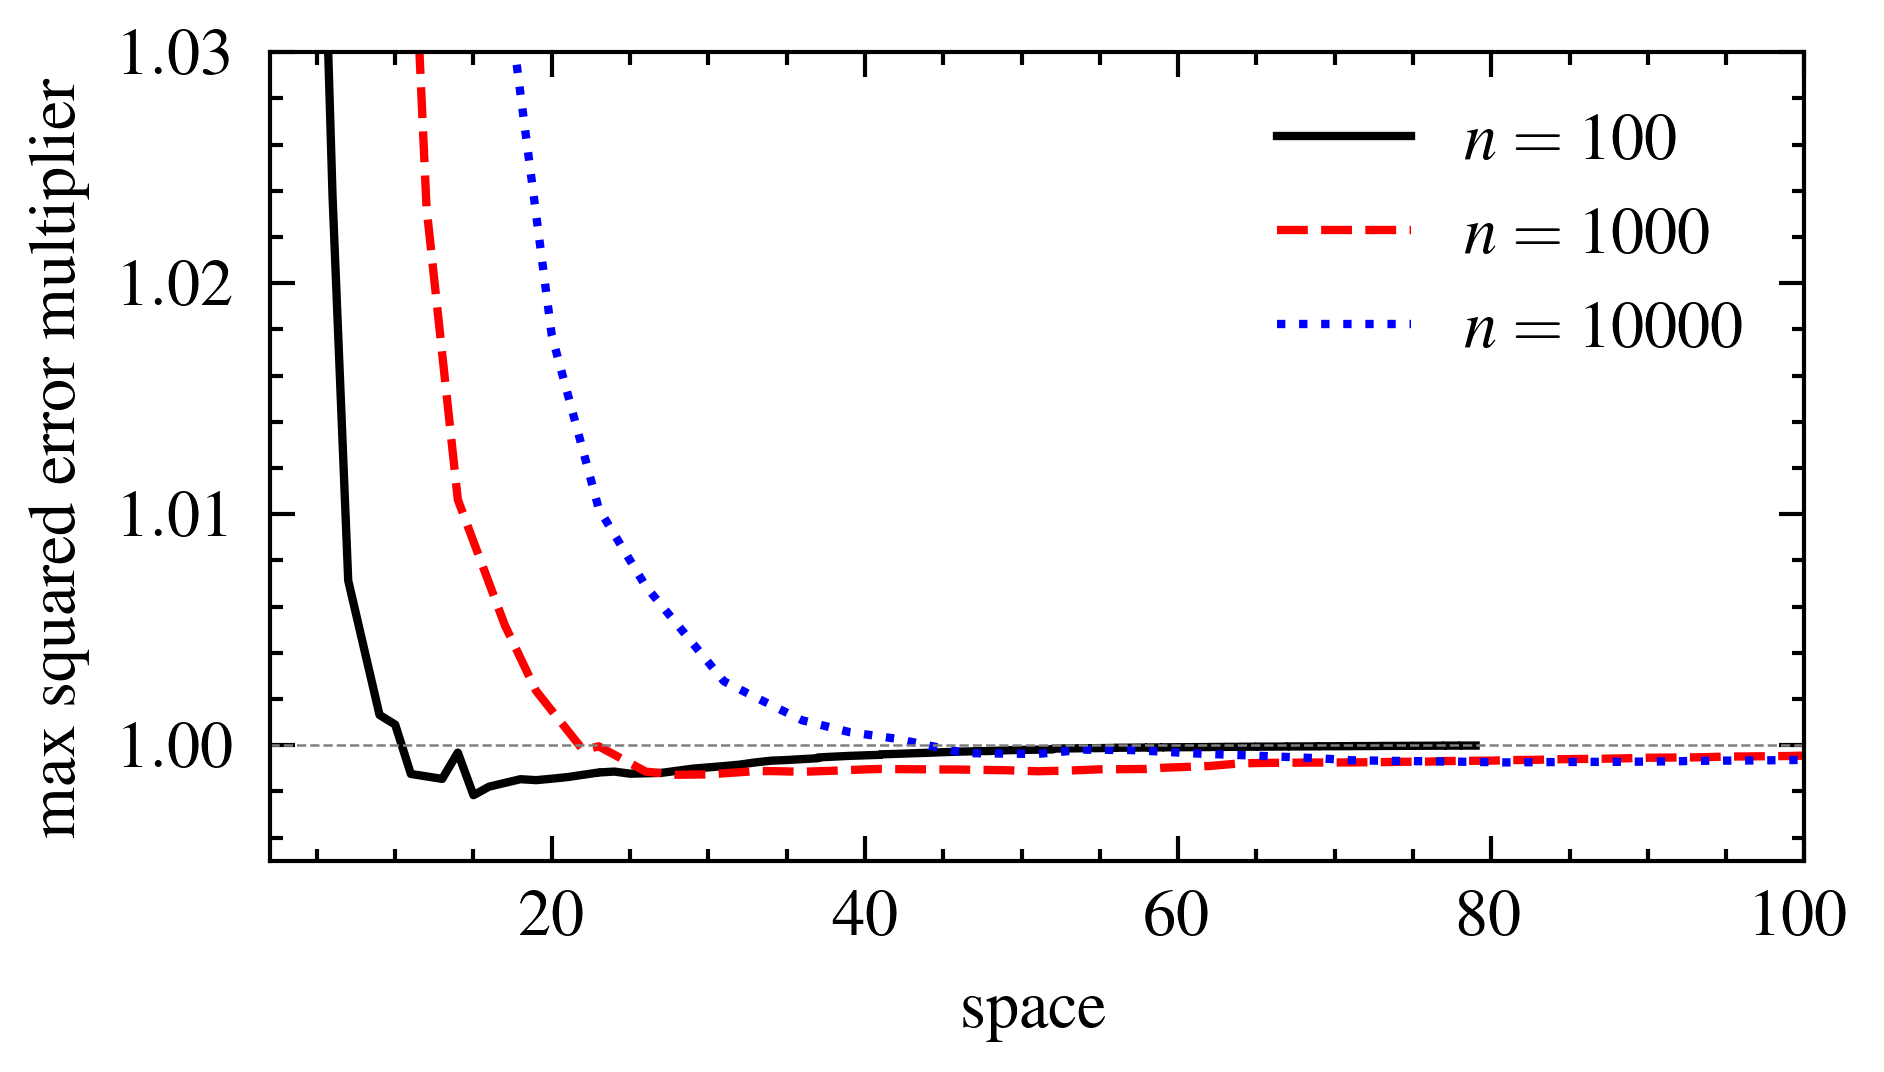

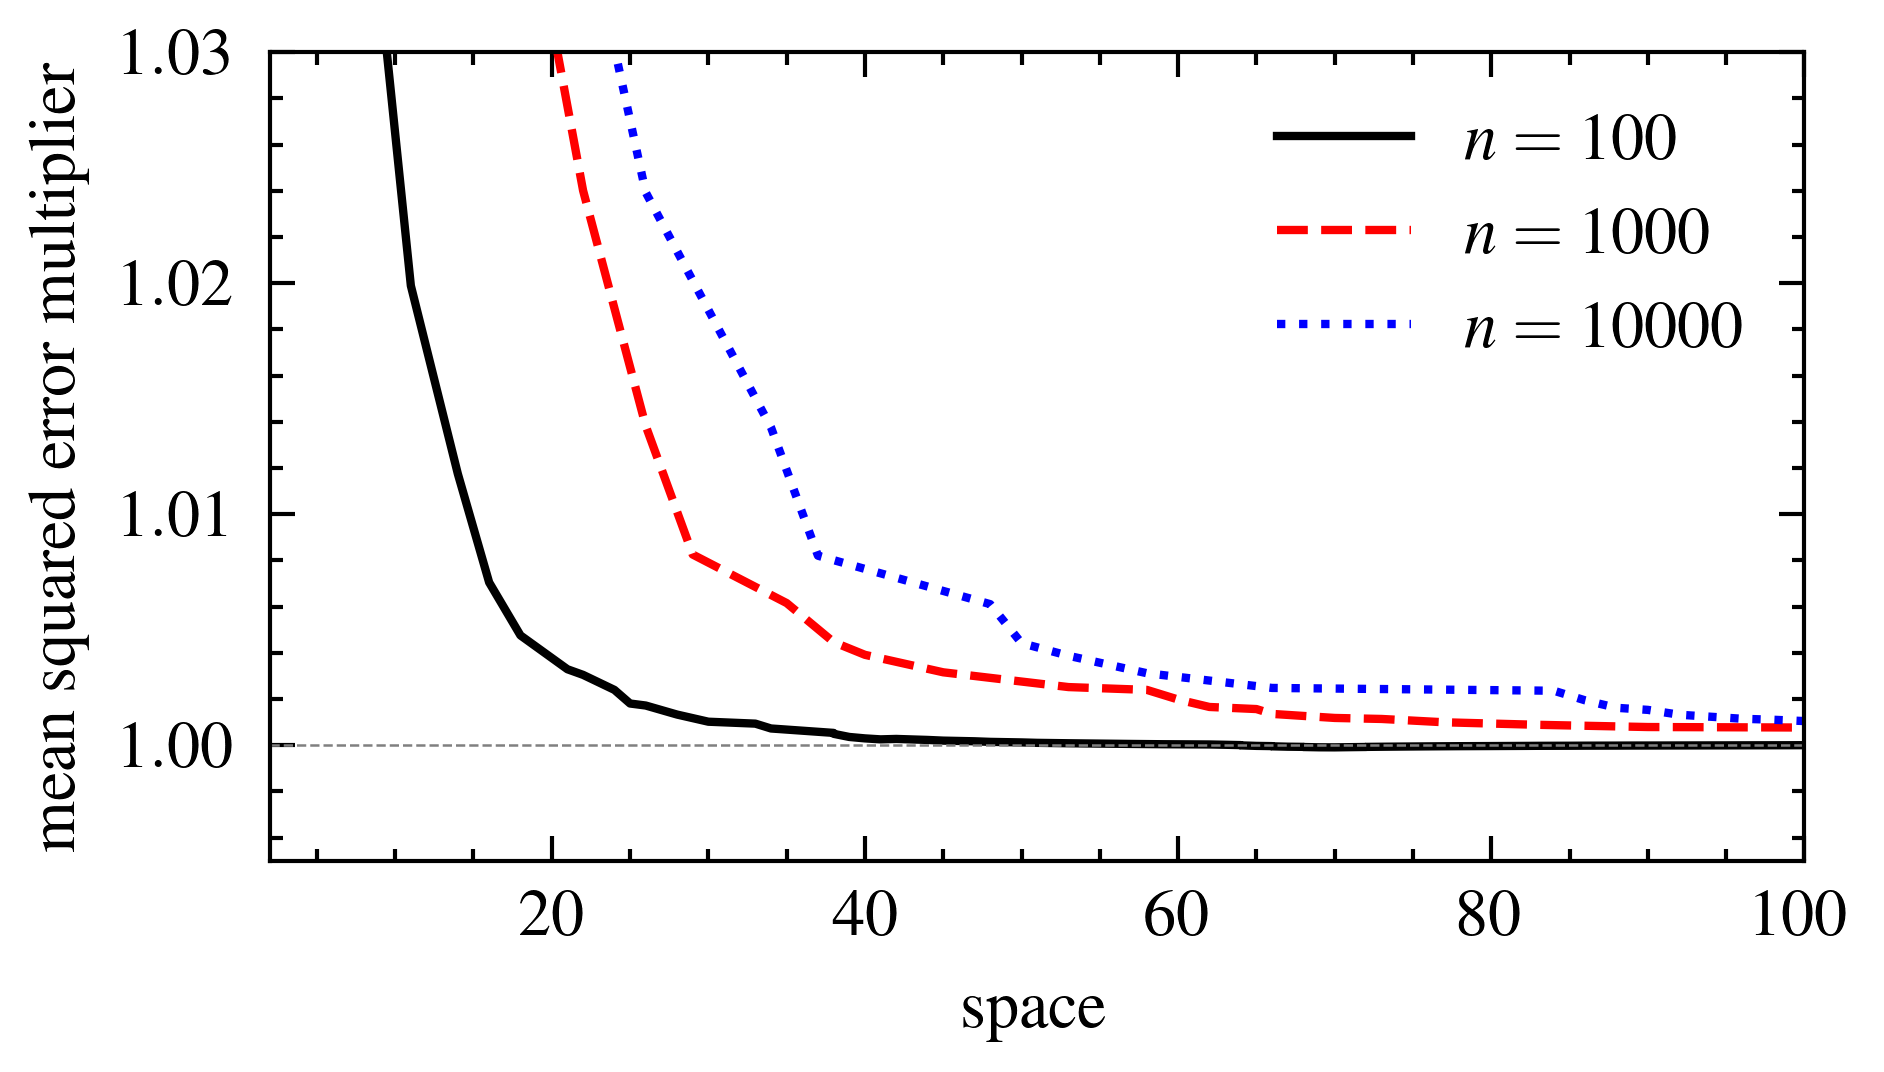

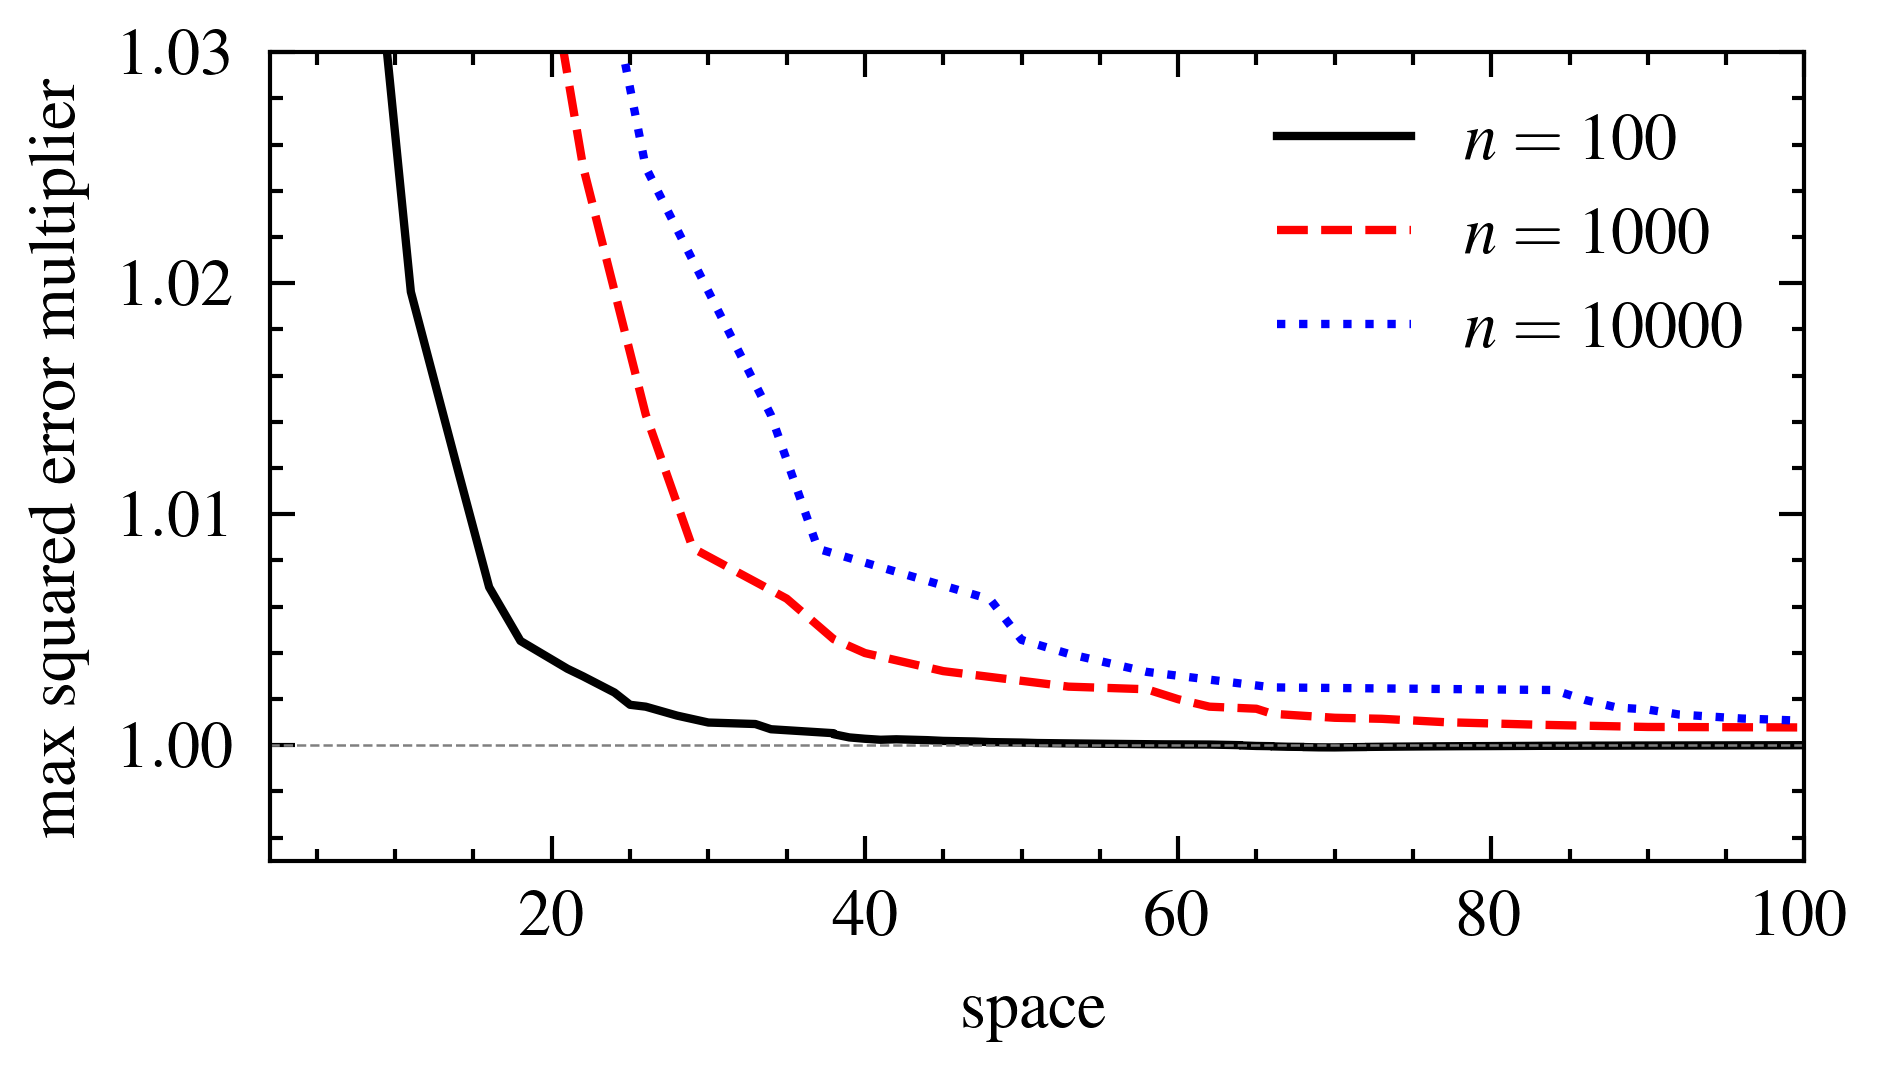

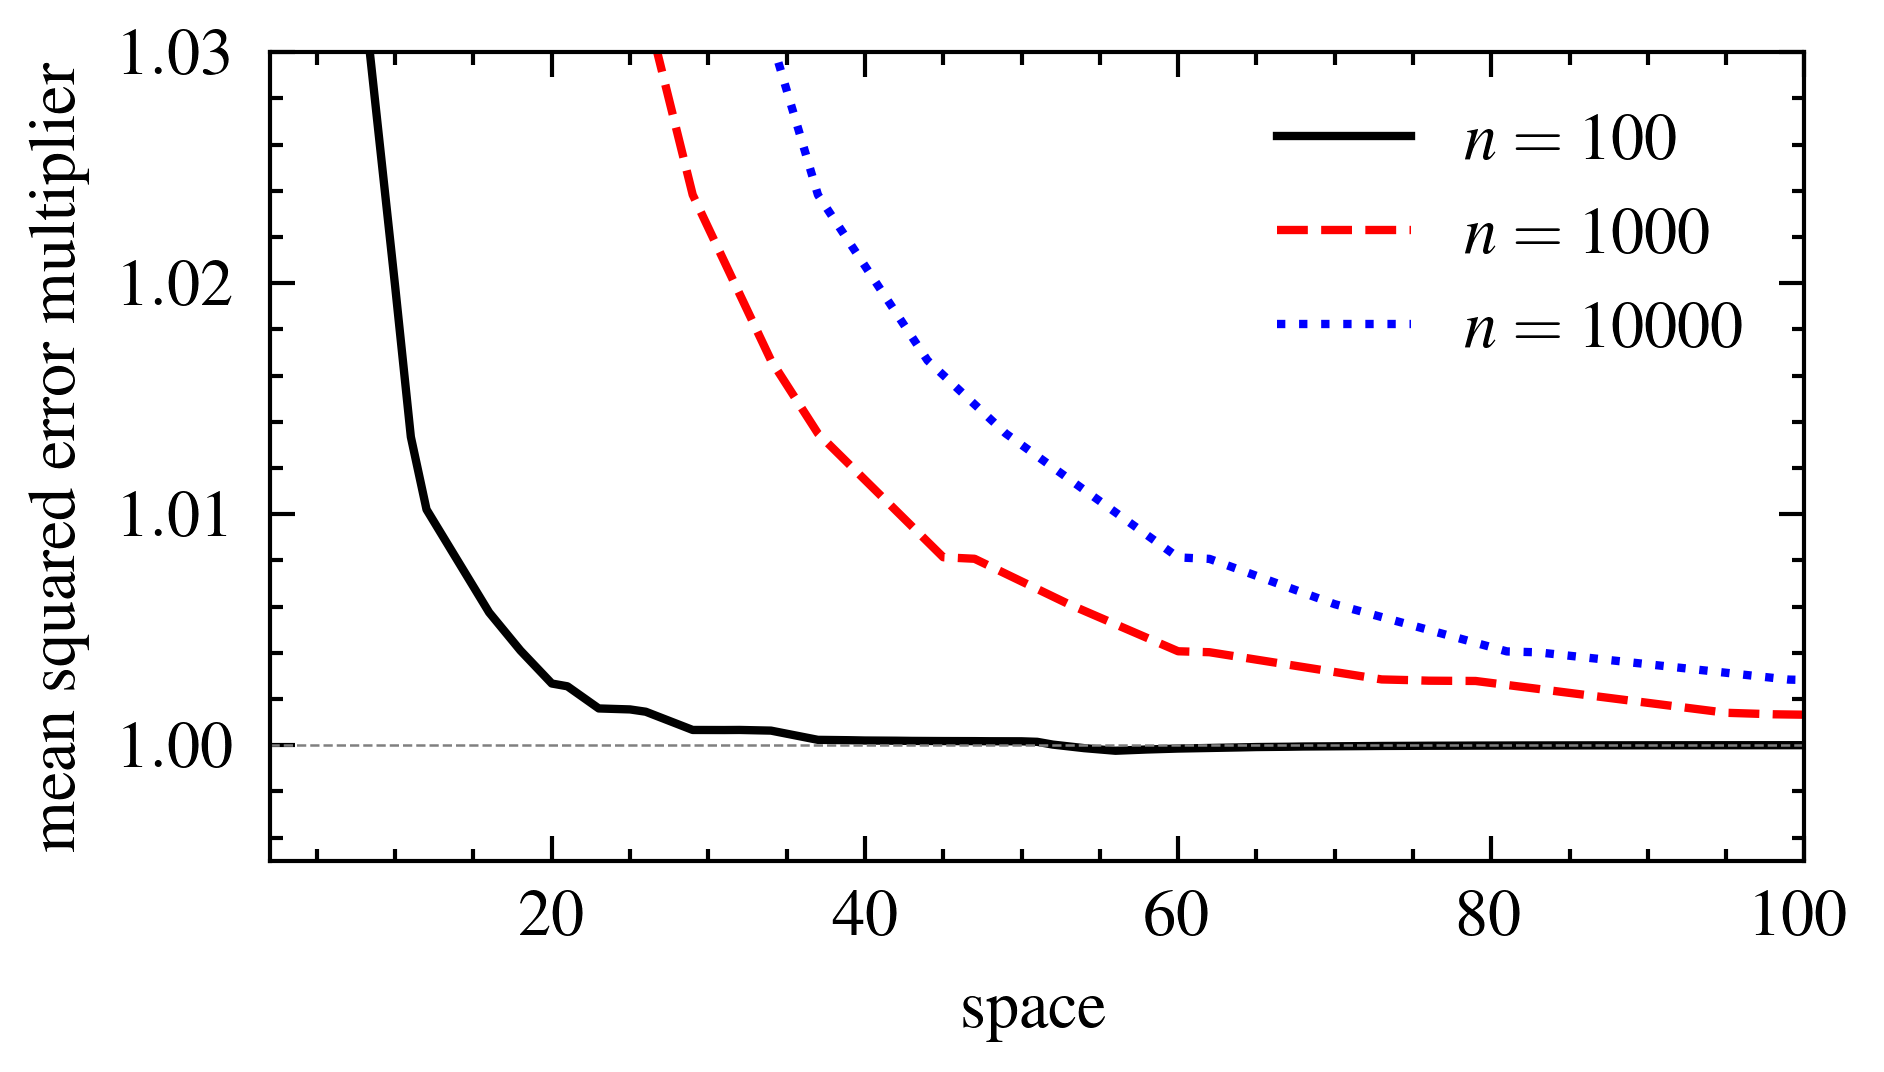

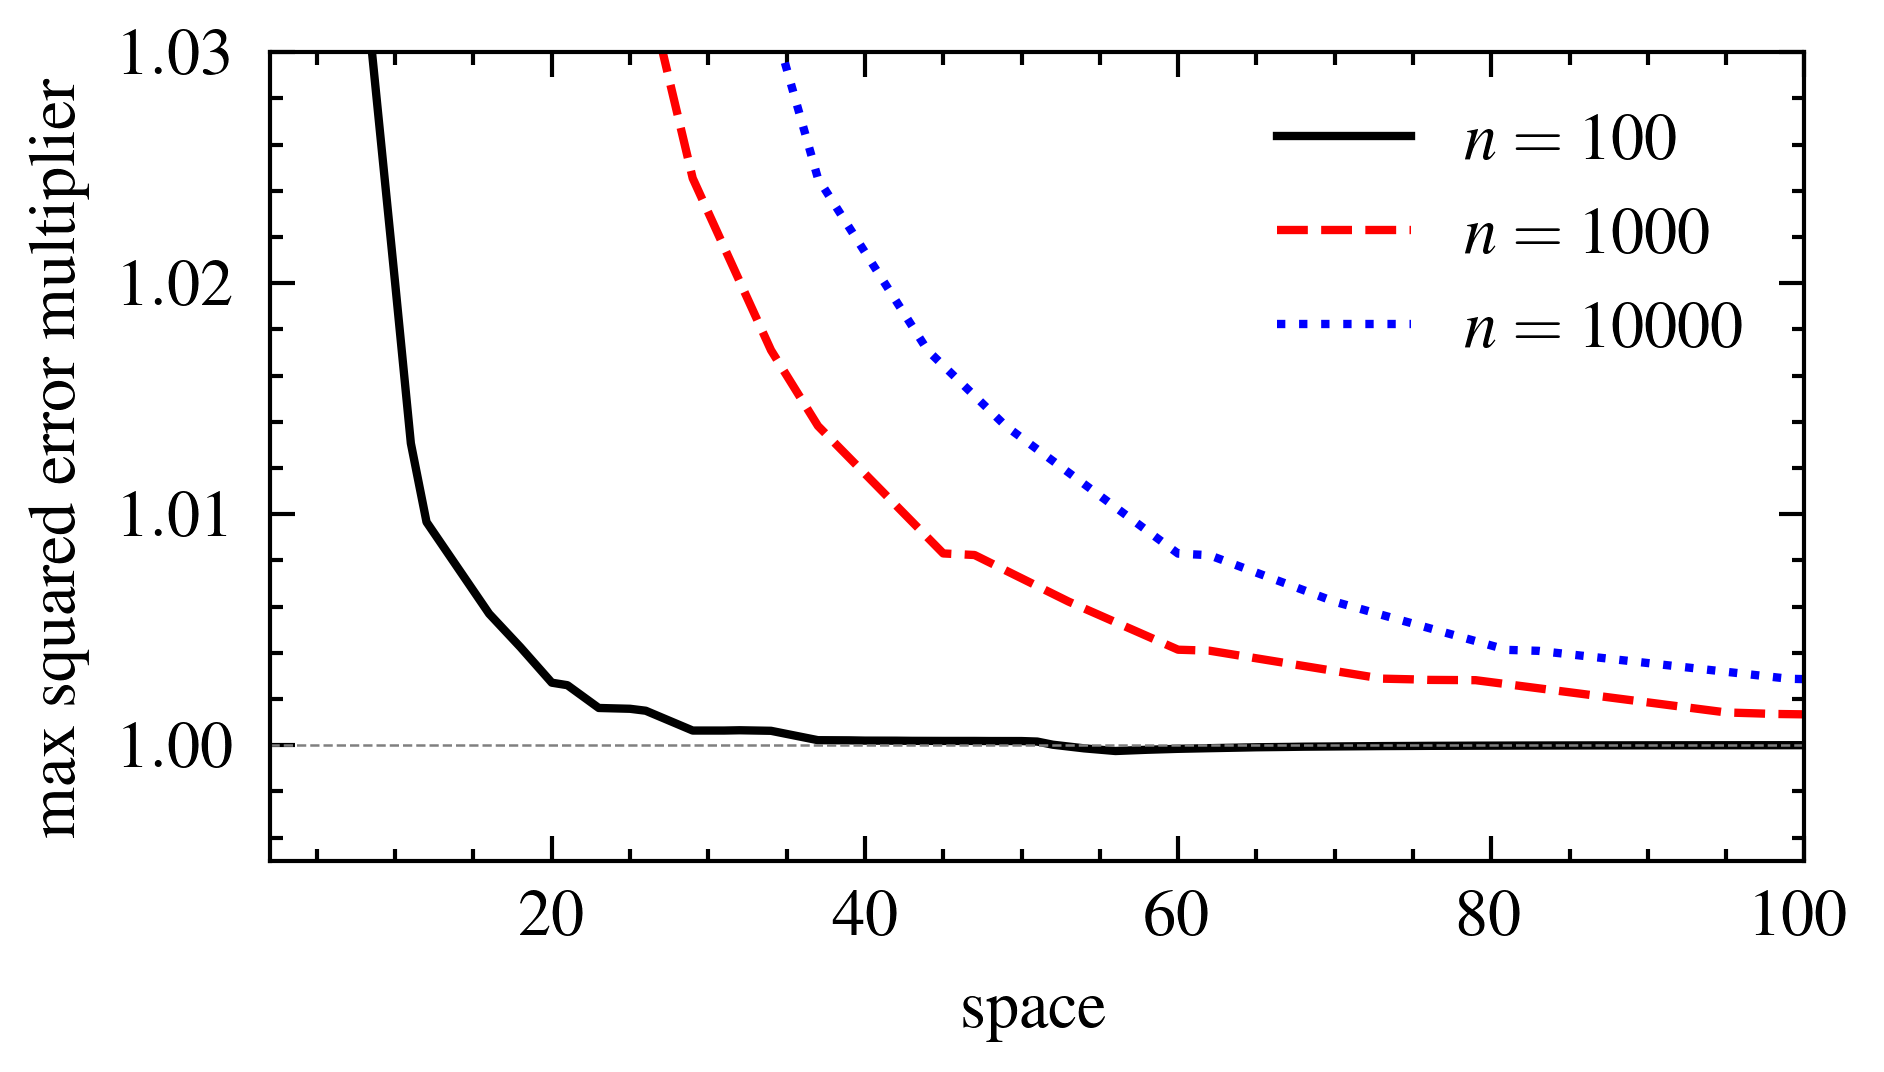

In [4]:
n_list = [100, 1000, 10000]

for alpha, beta in [(1, 0), (1, 0.95), (1, 0.9), (0.99, 0), (0.99, 0.95)]:
    for error_type in ['mean', 'max']:
        dfs = get_type2_figure_data(alpha=alpha, beta=beta, n_list=n_list, error_type=error_type)

        plt.figure(figsize=(FIGSIZE_ONE_COLUMN[0], 0.7 * FIGSIZE_ONE_COLUMN[1]))
        for n, df in dfs.items():
            plt.plot(df['space'], df['approx'], label=f'$n={n}$')
        plt.xlabel('space')
        plt.ylabel(f'{error_type} squared error multiplier')
        if alpha == 1 and beta == 0:
            plt.ylim([0.995, 1.01])
        else:
            plt.ylim([0.995, 1.03])
        plt.xlim([2, 100])
        plt.axhline(1.0, ls='--', lw=0.3, color='gray')
        plt.legend()
        plt.savefig(f'plots/{error_type}_mult_vs_space_a{alpha}b{beta}.pdf', bbox_inches='tight')
        plt.show()

# Figures 2 and 4

FileNotFoundError: [Errno 2] No such file or directory: 'new_figures/binned_L_a1b0.pdf'

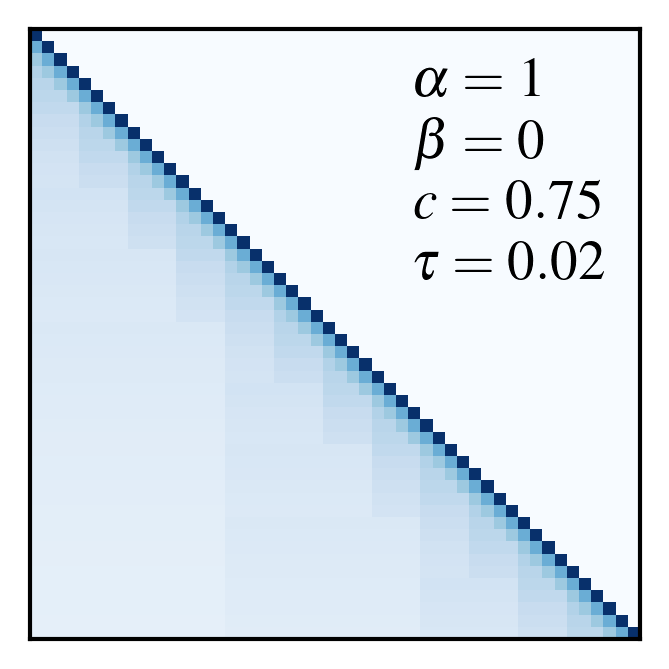

In [5]:
n = 50
alpha, beta, c, tau = 0.99, 0, 0.7, 1/n
params = [(1, 0, 0.75, 1/n), (0.99, 0, 0.7, 1/n), (1, 0.95, 0.9, 1/n)]

for alpha, beta, c, tau in params:
    L, R, our_space = binning.approx_counting_with_decay_momentum(n=n, alpha=alpha, beta=beta, c=c, tau=tau)
    B = binning.get_square_root_matrix(n=n, alpha=alpha, beta=beta)

    figsize=(FIGSIZE_ONE_COLUMN[0] * 0.4, FIGSIZE_ONE_COLUMN[0] * 0.4)
    plt.figure(figsize=figsize)
    plt.imshow(L, cmap='Blues', interpolation='nearest')
    plt.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        left=False,
        right=False,
        labelbottom=False,
        labelleft=False)
    plt.text(31, 5, rf'$\alpha={alpha}$', size='small')
    plt.text(31, 10, rf'$\beta={beta}$', size='small')
    plt.text(31, 15, rf'$c={c}$', size='small')
    plt.text(31, 20, rf'$\tau={tau}$', size='small')
    plt.savefig(f'new_figures/binned_L_a{alpha}b{beta}.pdf', bbox_inches='tight')
    plt.show()

    plt.figure(figsize=figsize)
    plt.imshow(R, cmap='Blues', interpolation='nearest')
    plt.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        left=False,
        right=False,
        labelbottom=False,
        labelleft=False)
    plt.text(31, 5, rf'$\alpha={alpha}$', size='small')
    plt.text(31, 10, rf'$\beta={beta}$', size='small')
    plt.text(31, 15, rf'$c={c}$', size='small')
    plt.text(31, 20, rf'$\tau={tau}$', size='small')
    plt.savefig(f'new_figures/induced_R_a{alpha}b{beta}.pdf', bbox_inches='tight')
    plt.show()

    plt.figure(figsize=figsize)
    plt.imshow(B, cmap='Blues', interpolation='nearest')
    plt.tick_params(
        axis='both',
        which='both',
        bottom=False,
        top=False,
        left=False,
        right=False,
        labelbottom=False,
        labelleft=False)
    plt.text(31, 5, rf'$\alpha={alpha}$', size='small')
    plt.text(31, 10, rf'$\beta={beta}$', size='small')
    plt.savefig(f'new_figures/sqrt_counting_matrix_a{alpha}b{beta}.pdf', bbox_inches='tight')
    plt.show()

    print(f"Our approximation: {binning.get_mse(L, R) / binning.get_mse(B, B)} in space {our_space}")
    print(np.abs(L @ R - B @ B).max())